In [0]:
%matplotlib inline

# Text documents classification by sparse features-plot

###[Banafsheh Hassani](https://www.linkedin.com/in/banafsheh-hassani-7b063a129/)

###[More Projects](https://github.com/BanafshehHassani)

[Reference](https://scikit-learn.org/0.19/auto_examples/text/document_classification_20newsgroups.html)

This notbook using scikit-learn to classify documents
by topics using a bag-of-words approach.With using a scipy.sparse
matrix for storing the features and demonstrates various classifiers which
efficiently handle sparse matrices.

#Data : sklearn.datasets.fetch_20newsgroups

* 20 newsgroups dataset is automaticaly download, catch and reuse for document classification.
* Automaticaly get 20 categories or user can giving category name to dataset for adjusting number of them.

In [0]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


Illustrate progress logs on stdout

In [0]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


Out[3]: <Option at 0x7f8cb41fd350: --filtered>2021-03-10 18:51:50,806 INFO Received command c on object id p0
2021-03-10 18:51:50,806 INFO Received command c on object id p0
2021-03-10 18:51:50,807 INFO Received command c on object id p0
2021-03-10 18:51:50,807 INFO Received command c on object id p0

In [0]:

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


2021-03-10 18:51:50,844 INFO Received command c on object id p0
2021-03-10 18:51:50,844 INFO Received command c on object id p0
2021-03-10 18:51:50,845 INFO Received command c on object id p0
2021-03-10 18:51:50,845 INFO Received command c on object id p0

In [0]:
print(__doc__)
op.print_help()
print()

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
Usage: PythonShell.py [options]

Options:
 -h, --help show this help message and exit
 --report Print a detailed classification report.
 --chi2_select=SELECT_CHI2
 Select some number of features using a chi-squared
 test
 --confusion_matrix Print the confusion matrix.
 --top10 Print ten most discriminative terms per class for
 every classifier.
 --all_categories Whether to use all categories or not.
 --use_hashing Use a hashing vectorizer.
 --n_features=N_FEATURES
 n_features when using the hashing vectorizer.
 --filtered Remove newsgroup information that is easily overfit:
 headers, signatures, and quoting.

2021-03-10 18:51:50,919 INFO Received command c on object id p0
2021-03-10 18:51:50,919 INFO Received command c on object id p0
2021-03-10 18:51:50,919 INFO Received command c on object id p0
2021-03-10 18:51:50,920 INFO Received command c on object id p0

Load data from training set
------------------------------------
Load data from the newsgroups dataset that comprises around 18000
newsgroups posts on 20 topics which split in two subsets: one for training (development), the other one for testing (or for performance evaluation).

In [0]:
if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
Downloading 20news dataset. This may take a few minutes.
2021-03-10 18:51:50,967 INFO Downloading 20news dataset. This may take a few minutes.
Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)
2021-03-10 18:51:50,967 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)
2021-03-10 18:51:51,957 INFO Received command c on object id p0
2021-03-10 18:51:51,957 INFO Received command c on object id p0
2021-03-10 18:51:51,958 INFO Received command c on object id p0
2021-03-10 18:51:51,958 INFO Received command c on object id p0
2021-03-10 18:51:51,959 INFO Received command c on object id p0
2021-03-10 18:51:51,959 INFO Received command c on object id p0
2021-03-10 18:51:51,959 INFO Received command c on object id p0
2021-03-10 18:51:51,959 INFO Received command c on object id p0
2021-03-10 18:51:52,057 INFO Received command c on object id p0
2021-03-10 18:51:52,164 INFO Received command c on object id p0
2021-03-10 18:51:52,244 INFO Received command c on object id p0
2021-03-10 18:51:52,245 INFO Received command c on object id p0
2021-03-10 18:51:52,247 INFO Received command c on object id p0
2021-03-10 18:51:52,247 INFO Received command c on object id p0
2021-03-10 18:51:52,248 INFO Received command c on object id p0
2021-03-10 18:51:52,248 INFO Received command c on object id p0
2021-03-10 18:51:52,248 INFO Received command c on object id p0
2021-03-10 18:51:52,248 INFO Received command c on object id p0
2021-03-10 18:51:52,264 INFO Received command c on object id p0
2021-03-10 18:51:52,365 INFO Received command c on object id p0
2021-03-10 18:51:52,465 INFO Received command c on object id p0
2021-03-10 18:51:52,566 INFO Received command c on object id p0
2021-03-10 18:51:52,667 INFO Received command c on object id p0
2021-03-10 18:51:52,746 INFO Received command c on object id p0
2021-03-10 18:51:52,746 INFO Received command c on object id p0
2021-03-10 18:51:52,746 INFO Received command c on object id p0
2021-03-10 18:51:52,747 INFO Received command c on object id p0
2021-03-10 18:51:52,748 INFO Received command c on object id p0
2021-03-10 18:51:52,748 INFO Received command c on object id p0
2021-03-10 18:51:52,749 INFO Received command c on object id p0
2021-03-10 18:51:52,749 INFO Received command c on object id p0
2021-03-10 18:51:52,767 INFO Received command c on object id p0
2021-03-10 18:51:52,868 INFO Received command c on object id p0
2021-03-10 18:51:52,968 INFO Received command c on object id p0
2021-03-10 18:51:53,069 INFO Received command c on object id p0
2021-03-10 18:51:53,170 INFO Received command c on object id p0
2021-03-10 18:51:53,246 INFO Received command c on object id p0
2021-03-10 18:51:53,246 INFO Received command c on object id p0
2021-03-10 18:51:53,247 INFO Received command c on object id p0
2021-03-10 18:51:53,247 INFO Received command c on object id p0
2021-03-10 18:51:53,248 INFO Received command c on object id p0
2021-03-10 18:51:53,248 INFO Received command c on object id p0
2021-03-10 18:51:53,249 INFO Received command c on object id p0
2021-03-10 18:51:53,250 INFO Received command c on object id p0
2021-03-10 18:51:53,270 INFO Received command c on object id p0
2021-03-10 18:51:53,371 INFO Received command c on object id p0
2021-03-10 18:51:53,472 INFO Received command c on object id p0
2021-03-10 18:51:53,573 INFO Received command c on object id p0
2021-03-10 18:51:53,673 INFO Received command c on object id p0
2021-03-10 18:51:53,747 INFO Received command c on object id p0
2021-03-10 18:51:53,750 INFO Received command c on object id p0
2021-03-10 18:51:53,750 INFO Received command c on object id p0
2021-03-10 18:51:53,751 INFO Received command c on object id p0
2021-03-10 18:51:53,751 INFO Received command c on object id p0
2021-03-10 18:51:53,752 INFO Received command c on object id p0
2021-03-10 18:51:53,752 INFO Recei

Order of labels in `target_names` would be different from `categories`

In [0]:
target_names = data_train.target_names

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories

2021-03-10 18:52:19,223 INFO Received command c on object id p0
2021-03-10 18:52:19,230 INFO Received command c on object id p0
2021-03-10 18:52:19,230 INFO Received command c on object id p0
2021-03-10 18:52:19,230 INFO Received command c on object id p0

# split a training set and a test set

In [0]:
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 0.581992s at 6.838MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.360658s at 7.951MB/s
n_samples: 1353, n_features: 33809

2021-03-10 18:52:20,273 INFO Received command c on object id p0
2021-03-10 18:52:20,274 INFO Received command c on object id p0
2021-03-10 18:52:20,274 INFO Received command c on object id p0
2021-03-10 18:52:20,274 INFO Received command c on object id p0
2021-03-10 18:52:20,275 INFO Received command c on object id p0
2021-03-10 18:52:20,275 INFO Received command c on object id p0
2021-03-10 18:52:20,275 INFO Received command c on object id p0
2021-03-10 18:52:20,275 INFO Received command c on object id p0
2021-03-10 18:52:20,276 INFO Received command c on object id p0
2021-03-10 18:52:20,276 INFO Received command c on object id p0
2021-03-10 18:52:20,276 INFO Received command c on object id p0
2021-03-10 18:52:20,277 INFO Received command c on object id p0

# Mapping from integer feature name to original token string

In [0]:
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

2021-03-10 18:52:20,358 INFO Received command c on object id p0
2021-03-10 18:52:20,359 INFO Received command c on object id p0
2021-03-10 18:52:20,359 INFO Received command c on object id p0
2021-03-10 18:52:20,360 INFO Received command c on object id p0
2021-03-10 18:52:20,360 INFO Received command c on object id p0
2021-03-10 18:52:20,360 INFO Received command c on object id p0
2021-03-10 18:52:20,360 INFO Received command c on object id p0
2021-03-10 18:52:20,361 INFO Received command c on object id p0
2021-03-10 18:52:20,361 INFO Received command c on object id p0
2021-03-10 18:52:20,361 INFO Received command c on object id p0
2021-03-10 18:52:20,362 INFO Received command c on object id p0
2021-03-10 18:52:20,362 INFO Received command c on object id p0

Benchmark classifiers
------------------------------------
We train and test the datasets with 15 different classification models
and get performance results for each model.

In [0]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

================================================================================
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
 max_iter=None, normalize=False, random_state=None, solver='sag',
 tol=0.01)
/databricks/python/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
 '"sag" solver requires many iterations to fit '
train time: 0.221s
test time: 0.002s
accuracy: 0.897
dimensionality: 33809
density: 1.000000


================================================================================
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
 fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
 penalty=None, random_state=0, shuffle=True, tol=0.001,
 validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.040s
test time: 0.004s
accuracy: 0.888
dimensionality: 33809
density: 0.255302


================================================================================
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
 early_stopping=False, fit_intercept=True,
 loss='hinge', max_iter=50, n_iter_no_change=5,
 n_jobs=None, random_state=None, shuffle=True,
 tol=0.001, validation_fraction=0.1, verbose=0,
 warm_start=False)
train time: 0.068s
test time: 0.004s
accuracy: 0.902
dimensionality: 33809
density: 0.703341


================================================================================
kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
 weights='uniform')
train time: 0.002s
test time: 0.315s
accuracy: 0.858

================================================================================
Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
 criterion='gini', max_depth=None, max_features='auto',
 max_leaf_nodes=None, max_samples=None,
 min_impurity_decrease=0.0, min_impurity_split=None,
 min_samples_leaf=1, min_samples_split=2,
 min_weight_fraction_leaf=0.0, n_estimators=100,
 n_jobs=None, oob_score=False, random_state=None,
 verbose=0, warm_start=False)
2021-03-10 18:52:21,400 INFO Received command c on object id p0
2021-03-10 18:52:21,400 INFO Received command c on object id p0
2021-03-10 18:52:21,400 INFO Received command c on object id p0
2021-03-10 18:52:21,402 INFO Received command c on object id p0
2021-03-10 18:52:21,403 INFO Received command c on object id p0
2021-03-10 18:52:21,403 INFO Received command c on object id p0
2021-03-10 18:52:21,404 INFO Received command c on object id p0
2021-03-10 18:52:21,404 INFO Received command c on object id p0
2021-03-10 18:52:21,500 INFO Received command c on object id p0
2021-03-10 18:52:21,600 INFO Received command c on object id p0
2021-03-10 18:52:21,701 INFO Received command c on object id p0
2021-03-10 18:52:21,802 INFO Received command c on object id p0
2021-03-10 18:52:21,860 INFO Received command c on object id p0
2021-03-10 18:52:21,861 INFO Received command c on object id p0
2021-03-10 18:52:21,862 INFO Received command c on object id p0
2021-03-10 18:52:21,864 INFO Received command c on object id p0
2021-03-10 18:52:21,864 INFO Received command c on object id p0
2021-03-10 18:52:21,865 INFO Received command c on object id 

# Train SGD with Elastic Net penalty

In [0]:
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

================================================================================
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
 l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
 n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
 power_t=0.5, random_state=None, shuffle=True, tol=0.001,
 validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.251s
test time: 0.004s
accuracy: 0.903
dimensionality: 33809
density: 0.188485


2021-03-10 18:52:24,531 INFO Received command c on object id p0
2021-03-10 18:52:24,532 INFO Received command c on object id p0
2021-03-10 18:52:24,532 INFO Received command c on object id p0
2021-03-10 18:52:24,533 INFO Received command c on object id p0
2021-03-10 18:52:24,533 INFO Received command c on object id p0
2021-03-10 18:52:24,533 INFO Received command c on object id p0
2021-03-10 18:52:24,534 INFO Received command c on object id p0
2021-03-10 18:52:24,534 INFO Received command c on object id p0
2021-03-10 18:52:24,535 INFO Received command c on object id p0
2021-03-10 18:52:24,535 INFO Received command c on object id p0
2021-03-10 18:52:24,535 INFO Received command c on object id p0
2021-03-10 18:52:24,536 INFO Received command c on object id p0

# Train NearestCentroid without threshold

In [0]:
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

================================================================================
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.006s
test time: 0.003s
accuracy: 0.855

2021-03-10 18:52:24,592 INFO Received command c on object id p0
2021-03-10 18:52:24,593 INFO Received command c on object id p0
2021-03-10 18:52:24,593 INFO Received command c on object id p0
2021-03-10 18:52:24,593 INFO Received command c on object id p0

# Train sparse Naive Bayes classifiers

In [0]:
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")

================================================================================
Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.008s
test time: 0.002s
accuracy: 0.899
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.009s
test time: 0.008s
accuracy: 0.884
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=False)
train time: 0.008s
test time: 0.002s
accuracy: 0.911
dimensionality: 33809
density: 1.000000


================================================================================
LinearSVC with L1-based feature selection
2021-03-10 18:52:24,678 INFO Received command c on object id p0
2021-03-10 18:52:24,678 INFO Received command c on object id p0
2021-03-10 18:52:24,679 INFO Received command c on object id p0
2021-03-10 18:52:24,679 INFO Received command c on object id p0

# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.

In [0]:
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

________________________________________________________________________________
Training: 
Pipeline(memory=None,
 steps=[('feature_selection',
 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
 dual=False,
 fit_intercept=True,
 intercept_scaling=1,
 loss='squared_hinge',
 max_iter=1000,
 multi_class='ovr',
 penalty='l1',
 random_state=None,
 tol=0.001, verbose=0),
 max_features=None, norm_order=1, prefit=False,
 threshold=None)),
 ('classification',
 LinearSVC(C=1.0, class_weight=None, dual=True,
 fit_intercept=True, intercept_scaling=1,
 loss='squared_hinge', max_iter=1000,
 multi_class='ovr', penalty='l2', random_state=None,
 tol=0.0001, verbose=0))],
 verbose=False)
train time: 0.287s
test time: 0.003s
accuracy: 0.880

2021-03-10 18:52:25,030 INFO Received command c on object id p0
2021-03-10 18:52:25,030 INFO Received command c on object id p0
2021-03-10 18:52:25,030 INFO Received command c on object id p0
2021-03-10 18:52:25,031 INFO Received command c on object id p0
2021-03-10 18:52:25,031 INFO Received command c on object id p0
2021-03-10 18:52:25,031 INFO Received command c on object id p0
2021-03-10 18:52:25,032 INFO Received command c on object id p0
2021-03-10 18:52:25,032 INFO Received command c on object id p0
2021-03-10 18:52:25,033 INFO Received command c on object id p0
2021-03-10 18:52:25,033 INFO Received command c on object id p0
2021-03-10 18:52:25,033 INFO Received command c on object id p0
2021-03-10 18:52:25,034 INFO Received command c on object id p0

Add plots
------------------------------------
The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.

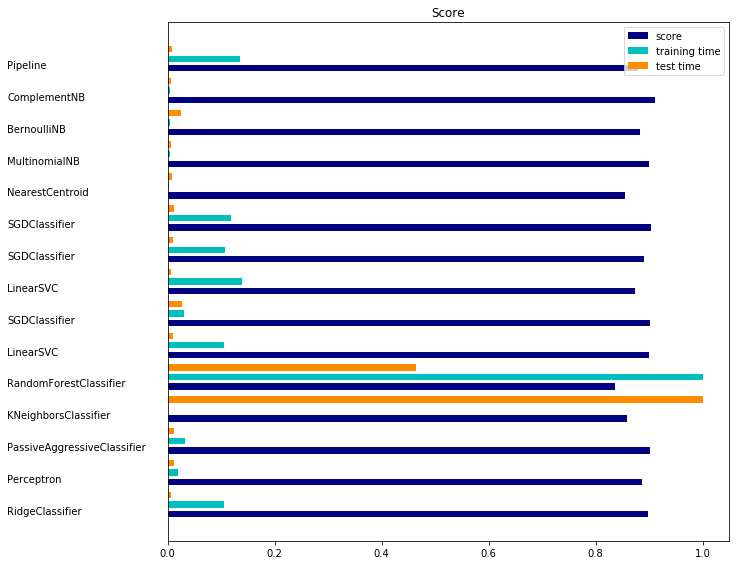

2021-03-10 18:52:25,528 INFO Received command c on object id p0
2021-03-10 18:52:25,528 INFO Received command c on object id p0
2021-03-10 18:52:25,528 INFO Received command c on object id p0
2021-03-10 18:52:25,529 INFO Received command c on object id p0
2021-03-10 18:52:25,529 INFO Received command c on object id p0
2021-03-10 18:52:25,529 INFO Received command c on object id p0
2021-03-10 18:52:25,529 INFO Received command c on object id p0
2021-03-10 18:52:25,530 INFO Received command c on object id p0
2021-03-10 18:52:25,530 INFO Received command c on object id p0
2021-03-10 18:52:25,530 INFO Received command c on object id p0
2021-03-10 18:52:25,531 INFO Received command c on object id p0
2021-03-10 18:52:25,531 INFO Received command c on object id p0

In [0]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()